<a href="https://colab.research.google.com/github/mmckeogh/scikit-learn/blob/main/Assignment_2_VVG16_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from PIL import Image
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.vgg16 import VGG16

from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, roc_curve, roc_auc_score, average_precision_score
import pandas as pd

import random
from matplotlib.image import imread

In [ ]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):

    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:

        #creating a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

# Test that GPU is available

In [ ]:
print(tf.test.is_gpu_available())

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False


In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    print("We got a GPU")
    #tf.config.experimental.set_memory_growth(physical_devices[0], True)
    os.environ["CUDA_VISIBLE_DEVICES"]="0"
else:
    print("Sorry, no GPU for you...")

print(tf.test.is_gpu_available(cuda_only=True))

Sorry, no GPU for you...
False


# Loading Data


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/archive'
train_path = '/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/archive/Train/Train'
test_path = '/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/archive/'
model_training = 0

class_head = 4096
n_classes= 43
IMG_HEIGHT = 32
IMG_WIDTH = 32
channels = 3
NUM_CATEGORIES = len(os.listdir(train_path))
NUM_CATEGORIES

# Number of training iterations called epochs
EPOCHS = 90
# Learning Rate
learning_rate = 0.0001
optim_2 = Adam(lr=learning_rate)

train_all_weights = 1 # 1 means train all weights of VGG16
if train_all_weights == 0:
    model_type = 'VGG16'
else:
    model_type = 'VGG16c'
#model_path = "./traffic_{}c_{}_I{}_vlr.h5".format(model_type,class_head,EPOCHS)
model_path = "/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/traffic_test_{}c_{}_Ies_vlr.h5".format(model_type,class_head)


# Callbacks
earlyStopping = EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10, verbose=0, mode='min')
mcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_loss', mode='min')
reduce_lr_loss = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, epsilon=1e-4, mode='min')


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Label Overview

In [ ]:
# Label Overview
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',
            2:'Speed limit (50km/h)',
            3:'Speed limit (60km/h)',
            4:'Speed limit (70km/h)',
            5:'Speed limit (80km/h)',
            6:'End of speed limit (80km/h)',
            7:'Speed limit (100km/h)',
            8:'Speed limit (120km/h)',
            9:'No passing',
            10:'No passing veh over 3.5 tons',
            11:'Right-of-way at intersection',
            12:'Priority road',
            13:'Yield',
            14:'Stop',
            15:'No vehicles',
            16:'Veh > 3.5 tons prohibited',
            17:'No entry',
            18:'General caution',
            19:'Dangerous curve left',
            20:'Dangerous curve right',
            21:'Double curve',
            22:'Bumpy road',
            23:'Slippery road',
            24:'Road narrows on the right',
            25:'Road work',
            26:'Traffic signals',
            27:'Pedestrians',
            28:'Children crossing',
            29:'Bicycles crossing',
            30:'Beware of ice/snow',
            31:'Wild animals crossing',
            32:'End speed + passing limits',
            33:'Turn right ahead',
            34:'Turn left ahead',
            35:'Ahead only',
            36:'Go straight or right',
            37:'Go straight or left',
            38:'Keep right',
            39:'Keep left',
            40:'Roundabout mandatory',
            41:'End of no passing',
            42:'End no passing veh > 3.5 tons' }


In [ ]:
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    #print(int(folder))
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])

# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

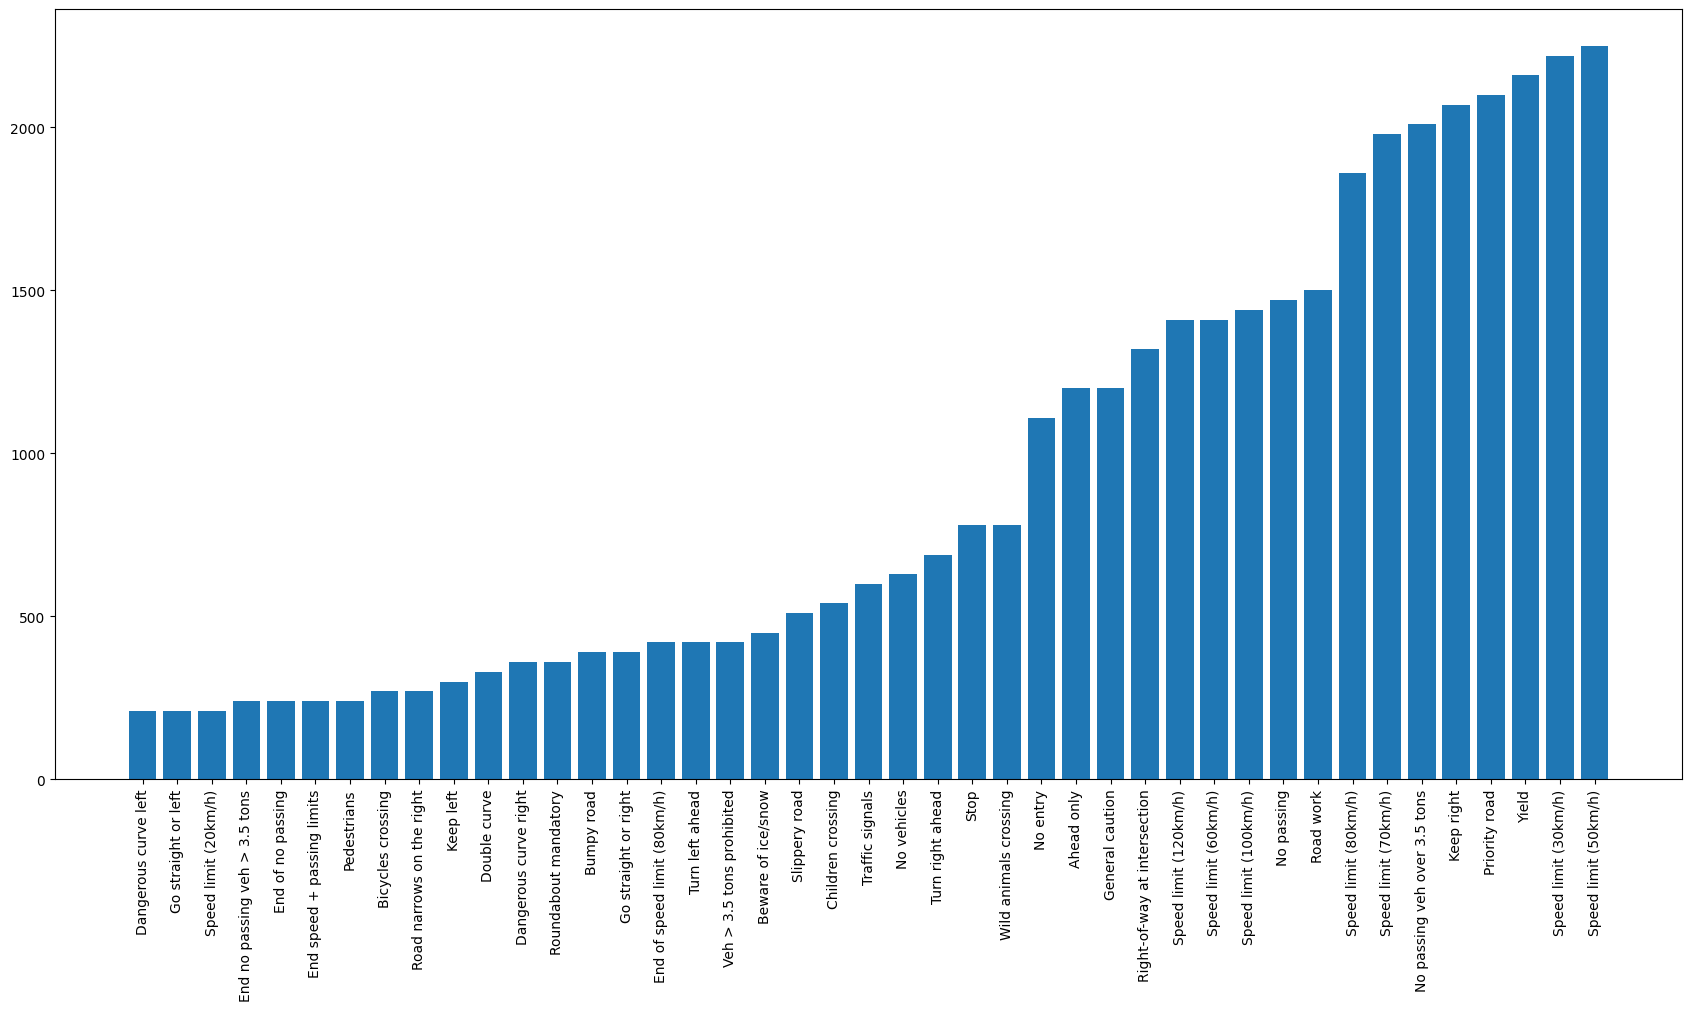

In [ ]:
# Plotting the number of images in each class
plt.figure(figsize=(21,10))
plt.bar(class_num, train_number)
plt.xticks(class_num, rotation='vertical')
plt.show()

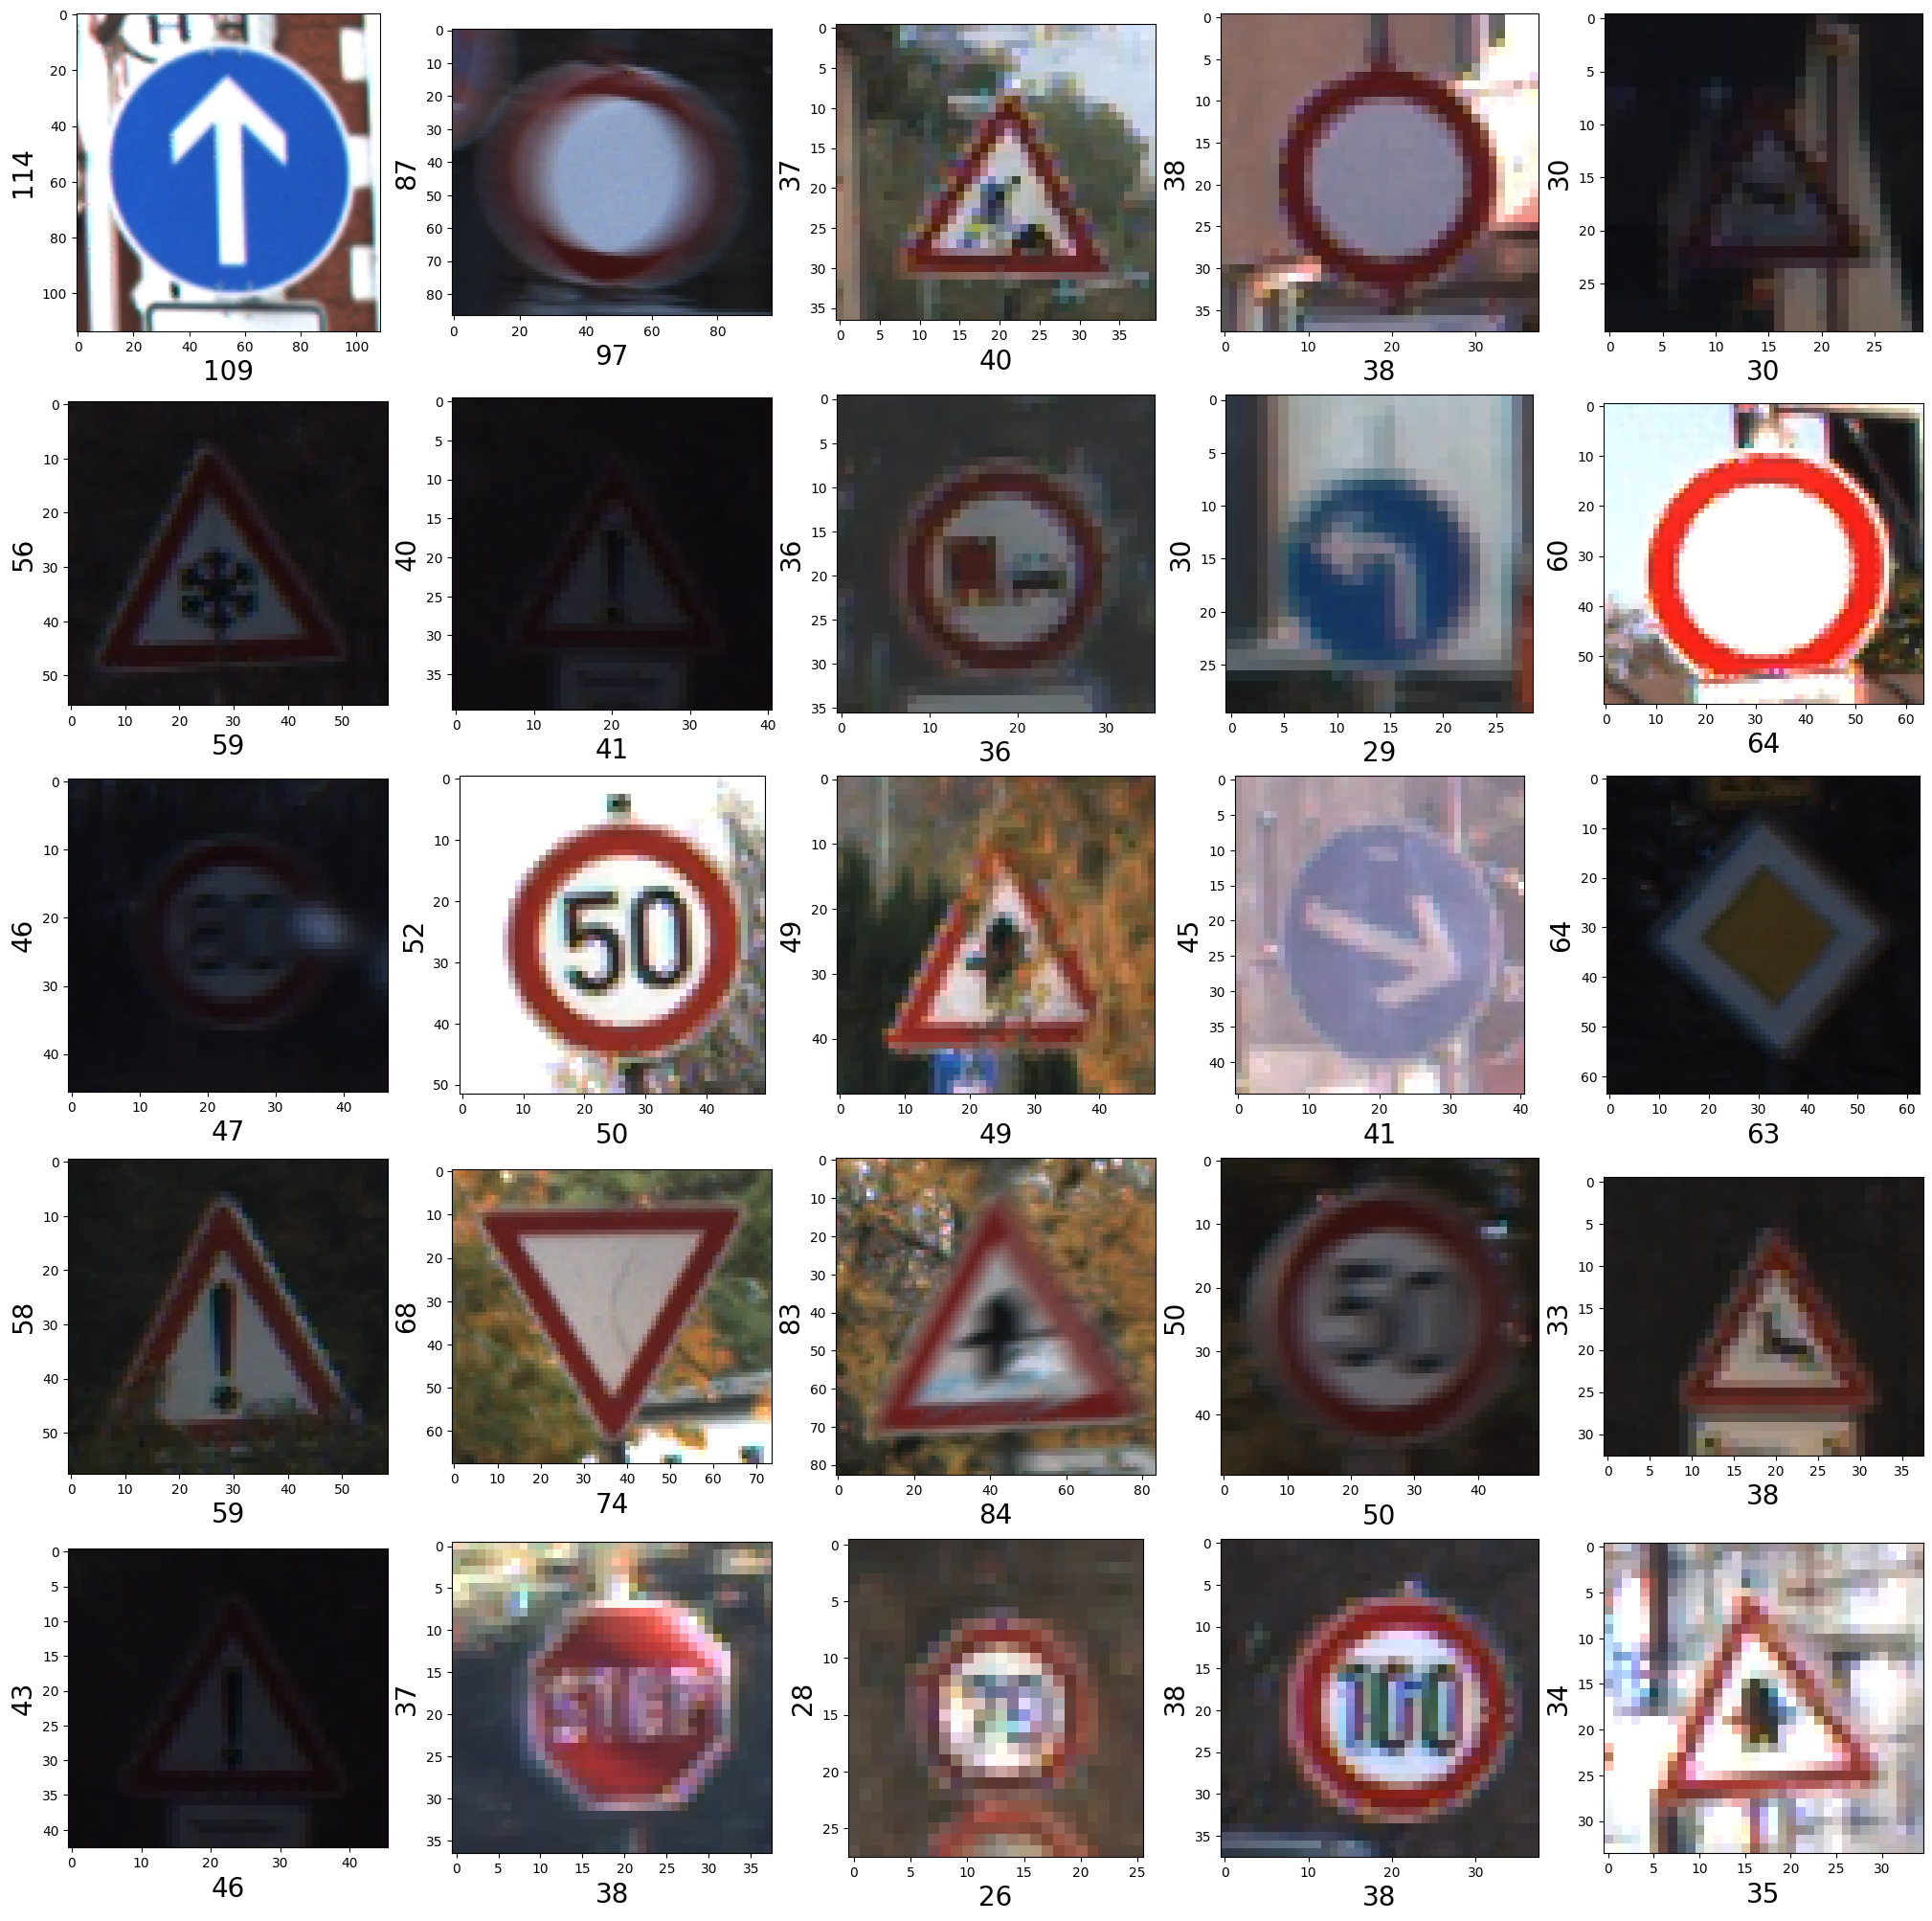

In [ ]:
# Visualizing 25 random images from test data

test = pd.read_csv(data_dir + '/Test.csv')
imgs = test["Path"].values

plt.figure(figsize=(25,25))

for i in range(1,26):
    plt.subplot(5,5,i)
    random_img_path = data_dir + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)
    plt.grid(visible=0)
    plt.xlabel(rand_img.shape[1], fontsize = 20)#width of image
    plt.ylabel(rand_img.shape[0], fontsize = 20)#height of image

plt.show()

In [ ]:
def load_data(data_dir,IMG_HEIGHT = 32,IMG_WIDTH = 32):

    images = list()
    labels = list()
    for category in range(NUM_CATEGORIES):
        categories = os.path.join(data_dir, str(category))
        for img in os.listdir(categories):
            img = load_img(os.path.join(categories, img), target_size=(IMG_HEIGHT, IMG_WIDTH))
            image = img_to_array(img)
            images.append(image)
            labels.append(category)

    return images, labels

In [ ]:
images, labels = load_data(train_path,IMG_HEIGHT,IMG_WIDTH)

In [ ]:
# One hot encoding the labels
labels = to_categorical(labels)

# Splitting the dataset into training and test set
x_train, x_test, y_train, y_test = train_test_split(
                                                    np.array(images),
                                                    labels,
                                                    test_size=0.3 ,
                                                    random_state=42,
                                                    shuffle=True
                                                    )

x_train = x_train/255
x_test = x_test/255

print("X_train.shape", x_train.shape)
print("X_valid.shape", x_test.shape)
print("y_train.shape", y_train.shape)
print("y_valid.shape", y_test.shape)

X_train.shape (27446, 32, 32, 3)
X_valid.shape (11763, 32, 32, 3)
y_train.shape (27446, 43)
y_valid.shape (11763, 43)


In [ ]:
aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.15,
    horizontal_flip=False,
    vertical_flip=False,
    fill_mode="nearest")

In [ ]:
n_classes=43
fine_tune=2
optim_2 = Adam(lr=0.0001)

mod_vgg16 = VGG16(weights='imagenet',input_shape=(IMG_HEIGHT,IMG_WIDTH,3),include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
print('Modified VGG16 Model')
for layer in mod_vgg16.layers:
    print(layer.get_output_at(0).get_shape().as_list())

# if train_all_weights == 1 all weights are changed
if train_all_weights == 0:
    # Setting only the number of layers to train
    if fine_tune > 0:
            for layer in mod_vgg16.layers[:-fine_tune]:
                layer.trainable = False
    else:
        for layer in mod_vgg16.layers:
            layer.trainable = False


Modified VGG16 Model
[None, 32, 32, 3]
[None, 32, 32, 64]
[None, 32, 32, 64]
[None, 16, 16, 64]
[None, 16, 16, 128]
[None, 16, 16, 128]
[None, 8, 8, 128]
[None, 8, 8, 256]
[None, 8, 8, 256]
[None, 8, 8, 256]
[None, 4, 4, 256]
[None, 4, 4, 512]
[None, 4, 4, 512]
[None, 4, 4, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 1, 1, 512]


Setting Up The VGG16 model to fine tune

In [ ]:
top_model = mod_vgg16.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(class_head, activation='relu',name="denseL1")(top_model)
top_model = Dense(class_head, activation='relu',name="denseL2")(top_model)
top_model = Dropout(0.2)(top_model)
output_layer = Dense(n_classes, activation='softmax',name="denseL3")(top_model)

model = Model(inputs=mod_vgg16.input, outputs=output_layer)

In [ ]:
print('our model')
for layer in model.layers:
    print(layer.get_output_at(0).get_shape().as_list())

model.summary()
model.compile(
    loss='categorical_crossentropy',
    optimizer=optim_2,
    metrics=['accuracy']
)

our model
[None, 32, 32, 3]
[None, 32, 32, 64]
[None, 32, 32, 64]
[None, 16, 16, 64]
[None, 16, 16, 128]
[None, 16, 16, 128]
[None, 8, 8, 128]
[None, 8, 8, 256]
[None, 8, 8, 256]
[None, 8, 8, 256]
[None, 4, 4, 256]
[None, 4, 4, 512]
[None, 4, 4, 512]
[None, 4, 4, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 2, 2, 512]
[None, 1, 1, 512]
[None, 512]
[None, 4096]
[None, 4096]
[None, 4096]
[None, 43]
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 

Train the model

Epoch 1/90
858/858 [==============================] - ETA: 0s - loss: 3.5177 - accuracy: 0.0542

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


858/858 [==============================] - 53s 47ms/step - loss: 3.5177 - accuracy: 0.0542 - val_loss: 3.4892 - val_accuracy: 0.0550 - lr: 0.0010
Epoch 2/90
858/858 [==============================] - 37s 43ms/step - loss: 3.4949 - accuracy: 0.0541 - val_loss: 3.4904 - val_accuracy: 0.0583 - lr: 0.0010
Epoch 3/90
858/858 [==============================] - 40s 46ms/step - loss: 3.4926 - accuracy: 0.0566 - val_loss: 3.4869 - val_accuracy: 0.0526 - lr: 0.0010
Epoch 4/90
858/858 [==============================] - 40s 46ms/step - loss: 3.4915 - accuracy: 0.0550 - val_loss: 3.4866 - val_accuracy: 0.0583 - lr: 0.0010
Epoch 5/90
858/858 [==============================] - 40s 46ms/step - loss: 3.4919 - accuracy: 0.0565 - val_loss: 3.4858 - val_accuracy: 0.0556 - lr: 0.0010
Epoch 6/90
858/858 [==============================] - 38s 44ms/step - loss: 3.4912 - accuracy: 0.0527 - val_loss: 3.4864 - val_accuracy: 0.0598 - lr: 0.0010
Epoch 7/90
858/858 [==============================] - 37s 44ms/step -

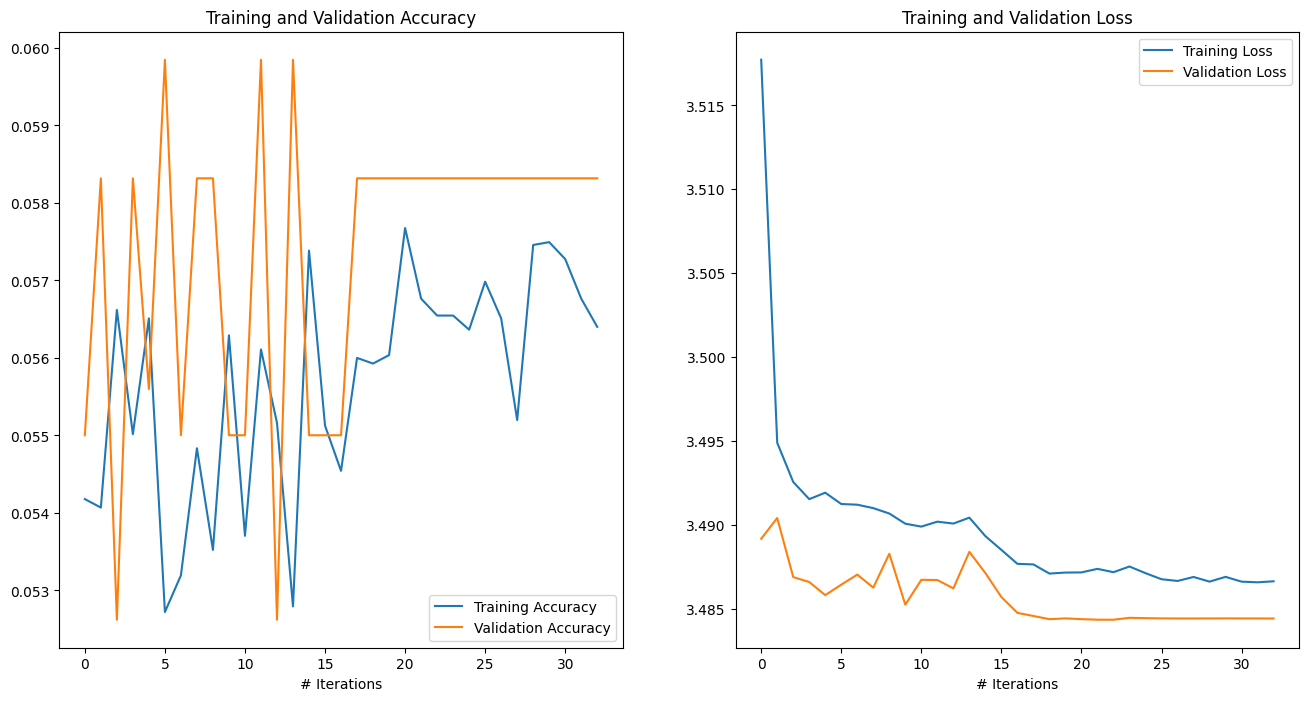

In [ ]:
if model_training == 1:

    model_out_dir = model_path

    history = model.fit(aug.flow(x_train,
                        y_train, batch_size = 32),
                        validation_data = (x_test, y_test),
                        epochs=EPOCHS,
                        callbacks=[earlyStopping, mcp_save, reduce_lr_loss]
                    )



    model.save(model_out_dir) # Saving the model weights

    loss, accuracy = model.evaluate(x_test, y_test)

    print('test set accuracy: ', accuracy * 100)

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    loss=history.history['loss']
    val_loss=history.history['val_loss']

    epochs_range = range(len(accuracy))

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label='Training Accuracy')
    plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('# Iterations')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('# Iterations')
    plt.show()

elif model_training ==0:

    model.load_weights(model_path)

Testing the model performance

In [ ]:
model.load_weights('/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/traffic_test_VGG16cc_4096_Ies_vlr.h5')

In [17]:
######### Model Testing

#Y_test = pd.read_csv(test_path + 'Test.csv')
Y_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Michaels file/Assignment 2/archive/Test.csv')
test_labels = Y_test["ClassId"].values
test_images = Y_test["Path"].values

output = list()
for img in test_images:
    image = load_img(os.path.join(test_path, img), target_size=(IMG_HEIGHT, IMG_WIDTH))
    output.append(np.array(image))

X_test=np.array(output)
pred = model.predict(X_test)
pred=np.argmax(pred, axis=1)

NameError: ignored

In [ ]:
print("X_test.shape", X_test.shape)
print("pred.shape", pred.shape)
print("test_labels.shape", test_labels.shape)

#Accuracy with the test data
print("{}_{}_I{}_acc = ".format(model_type,class_head,EPOCHS),accuracy_score(test_labels, pred)*100)
#F1 Score with the test data
print("{}_{}_I{}_F1 = ".format(model_type,class_head,EPOCHS),f1_score(test_labels, pred,average='weighted'))
#Recall with the test data
print("{}_{}_I{}_recall = ".format(model_type,class_head,EPOCHS),recall_score(test_labels, pred,average='weighted')*100)
# ROC metrics
print("ROC_{}_{}_I{} = ".format(model_type,class_head,EPOCHS), roc_auc_score_multiclass(test_labels, pred))


NameError: ignored

NameError: ignored

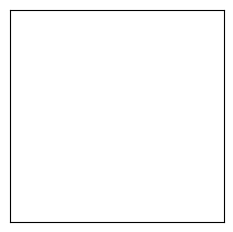

In [ ]:
plt.figure(figsize = (16, 16))

start_index = 0
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    prediction = pred[start_index + i]
    actual = test_labels[start_index + i]
    col = 'g'
    if prediction != actual:
        col = 'r'
    plt.xlabel('Actual={} || Pred={}'.format(actual, prediction), color = col)
    plt.imshow(X_test[start_index + i])
plt.show()